# Leveraging Machine Learning to Identify Phishing Websites
**Authors:** Ethan Dinh, Izzy Harker, Annika Huston <br>
**Date:** 9 February 2024 <br>
**Class:** CS 433 – Network Security

### Goal
> The primary goal of leveraging machine learning to identify phishing websites is to develop an automated, efficient, and highly accurate system capable of detecting and classifying websites as legitimate or phishing. This system aims to analyze various characteristics of websites, such as URL structure, site content, and metadata, to identify potential phishing attempts. By continuously learning from new data, the model seeks to improve its detection capabilities over time, adapting to the evolving tactics used by cybercriminals.

### Purpose
> The purpose of this initiative is to enhance cybersecurity measures by providing a robust tool that can significantly reduce the risk of phishing attacks for individuals and organizations. By automating the detection of phishing websites, the system intends to preemptively block access to these malicious sites, thereby protecting sensitive information from being compromised. Additionally, this project aims to raise awareness about the sophistication of phishing schemes and promote safer online practices among internet users. Ultimately, leveraging machine learning for phishing website identification supports the broader objective of creating a safer, more secure digital environment for all users.

# Table of Contents
1. [Importing Libraries](#LIBS)
2. [Importing & Cleaning Data Files](#FILTER)
3. [Feature Selection](#FEATURE)
4. [Implementing & Comparing Various Machine Learning Models](#IMPLEMENT)
5. [Hyper Parameter Tuning](#TUNE)
5. [Extrapolation](#EXTRA)

## Importing Core Libraries
<a class="anchor" id="LIBS"></a>

In [1]:
import pandas as pd
import os

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import warnings

warnings.filterwarnings('ignore')

## Importing & Cleaning Data Files
URL: https://www.sciencedirect.com/science/article/pii/S2352340920313202

Overview: 
* These data consist of a collection of legitimate, as well as phishing website instances. Each website is represented by the set of features that denote whether the website is legitimate or not. Data can serve as input for the machine learning process.
* Machine learning and data mining researchers can benefit from these datasets, while also computer security researchers and practitioners. Computer security enthusiasts can find these datasets interesting for building firewalls, intelligent ad blockers, and malware detection systems.
* This dataset can help researchers and practitioners easily build classification models in systems preventing phishing attacks since the presented datasets feature the attributes which can be easily extracted.
* Finally, the provided datasets could also be used as a performance benchmark for developing state-of-the-art machine learning methods for the task of phishing websites classification.

<a class="anchor" id="FILTER"></a>

In [2]:
# Include the file path of the data files here:
filePath = "~/Desktop/CS 433/Final Project/Input Data/"

# Loading in data
df = pd.read_csv(filePath + "dataset_small.csv")

# Remove all null rows
df = df.dropna()

## Feature Selection
<a class="anchor" id="FEATURE"></a>
We will be using recursive feature elimination, or RFE as a feature selection algorithm. RFE is a wrapper-type feature selection algorithm which implies that a different machine learning model will be used to help assist in the feature selection process. In general, RFE works by searching for a subset of features by starting with all features in the training dataset and removing features until the desired number remains. This process is done by fitting the given machine learning model, ranking features by importance, and removing the least important features, and re-fitting the model. 

In [3]:
# Importing the necessary libraries to pick the best features
from sklearn.feature_selection import RFE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict
from pyHSICLasso import HSICLasso

In [4]:
# Split the data into training and test sets
# Retrieving the features
features = df.columns[:-1]
X = df[features]
Y = df['phishing']

# Split DF into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=1, train_size = .75)

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)
print(y_train.value_counts())

(43983, 111) (14662, 111)
(43983,) (14662,)
1    22961
0    21022
Name: phishing, dtype: int64


### Understanding LDA and RFE

- **Linear Discriminant Analysis (LDA)** is a technique used both for dimensionality reduction and as a classifier. For dimensionality reduction, LDA seeks to find a projection that maximizes the separation between multiple classes.
- **Recursive Feature Elimination (RFE)** is a feature selection method that recursively removes features, building the model with the remaining features to identify which ones contribute most to predicting the target variable.

### When Combining Them Might Make Sense

- **Feature Selection for Classification**: If you're using LDA as a classifier, employing RFE to select features could potentially improve your model's performance by eliminating irrelevant or redundant features that don't contribute to separating the classes.
- **Dimensionality Reduction in Multi-step Process**: In scenarios where you're dealing with high-dimensional data but want to use LDA for classification rather than dimensionality reduction, RFE can help reduce dimensionality first, possibly enhancing LDA's classification performance.

### Considerations and Alternatives

- **Redundancy in Dimensionality Reduction**: LDA inherently performs a form of dimensionality reduction by projecting features onto a lower-dimensional space that maximizes class separability. Using RFE for further dimensionality reduction before LDA might be redundant or unnecessary, especially if the primary goal is dimensionality reduction rather than feature selection.
- **Compatibility with LDA Objectives**: If the main goal is to use LDA for its dimensionality reduction capabilities to facilitate another classifier's performance, consider whether RFE aligns with your objectives. RFE is more about selecting features based on their importance, which might or might not align with the goal of maximizing class separability in the reduced-dimensional space.
- **Alternatives to RFE**: Depending on your dataset and goals, other feature selection or dimensionality reduction techniques might be more straightforward or effective when combined with LDA. For example, methods like Principal Component Analysis (PCA) for dimensionality reduction (without considering class labels) or model-based feature selection techniques that consider feature importance might be alternatives to explore.

In [5]:
# Adapted from https://machinelearningmastery.com/rfe-feature-selection-in-python/
from sklearn.feature_selection import RFE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_predict, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Retrieves a list of models to evaluate
def get_models():
    models = dict()
    for i in range(10, 26):
        rfe = RFE(estimator=LDA(), n_features_to_select=i)
        model = DecisionTreeClassifier()
        models[str(i)] = Pipeline(steps=[('s', rfe), ('m', model)])
    return models

def evaluate_model(model, X, y):
    cv = KFold(n_splits=5)
    
    # Make sure to use X and y instead of X_train and y_train
    y_pred = cross_val_predict(model, X, y, cv=cv, n_jobs=-1, method='predict')
    
    # Calculate the confusion matrix
    conf_matrix = confusion_matrix(y, y_pred)
    
    # Calculate accuracy, precision, recall, and F1 score for a comprehensive evaluation
    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred, average='weighted')
    recall = recall_score(y, y_pred, average='weighted')
    f1 = f1_score(y, y_pred, average='weighted')
    
    # Calculate cross-validated accuracy score for comparison, using X and y
    cv_scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
    
    return {
        'Confusion Matrix': conf_matrix,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'CV Accuracy Scores': cv_scores,
        'CV Accuracy Mean': cv_scores.mean(),
        'CV Accuracy Std': cv_scores.std()
    }

In [6]:
def evaluate_num_feats():
    # Standardize the dataset
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    models = get_models()
    all_results = []
    for name, model in models.items():
        output_dict = evaluate_model(model, X_scaled, Y)
        print('>%s %.3f (%.3f)' % (name, output_dict['CV Accuracy Mean'], output_dict['CV Accuracy Std']))
        
        # Exclude 'CV Accuracy Scores' from the dictionary
        output_dict.pop('CV Accuracy Scores', None)
        
        # Add the model name or the number of features as a new key-value pair
        output_dict['Features'] = name
        
        all_results.append(output_dict)

    # Convert the list of dictionaries to a DataFrame
    results_df = pd.DataFrame(all_results)

    # Save the DataFrame to CSV
    results_df.to_csv('model_evaluation_results.csv', index=False)
    
# Check if the model evaluation results CSV file exists
if not os.path.exists('model_evaluation_results.csv'):
    evaluate_num_feats()

>10 0.884 (0.010)
>11 0.891 (0.007)
>12 0.900 (0.005)
>13 0.903 (0.005)
>14 0.907 (0.006)
>15 0.907 (0.006)
>16 0.910 (0.008)
>17 0.913 (0.008)
>18 0.916 (0.006)
>19 0.920 (0.006)
>20 0.922 (0.004)
>21 0.923 (0.004)
>22 0.924 (0.004)
>23 0.925 (0.001)
>24 0.925 (0.001)
>25 0.926 (0.001)


Precision, recall, and F1 score are metrics used to evaluate the quality of classification models, especially in the context of imbalanced datasets where accuracy might not provide a complete picture of the model's performance. Here's how to interpret each of these metrics:

### Precision
- **Definition**: Precision measures the accuracy of the positive predictions. It is the ratio of true positive predictions to the total predicted positives, which includes both true positives and false positives.
- **Formula**: Precision = True Positives / (True Positives + False Positives)
- **Interpretation**: A high precision score indicates that the model is reliable in its positive predictions, meaning when it predicts a class, it is likely correct. However, a model can achieve high precision by being overly conservative, possibly missing many true positives (i.e., it predicts positive only when very sure).

### Recall (Sensitivity)
- **Definition**: Recall measures the ability of the model to identify all relevant instances within a dataset. It is the ratio of true positive predictions to the actual positives in the data, which includes both true positives and false negatives.
- **Formula**: Recall = True Positives / (True Positives + False Negatives)
- **Interpretation**: A high recall score indicates that the model is good at detecting positive instances, capturing a large proportion of actual positives. However, a model can achieve high recall at the cost of making many incorrect positive predictions (i.e., low precision).

### F1 Score
- **Definition**: The F1 score is the harmonic mean of precision and recall, providing a single metric that balances both the precision and recall of a model.
- **Formula**: F1 Score = 2 * (Precision * Recall) / (Precision + Recall)
- **Interpretation**: The F1 score considers both false positives and false negatives, providing a more comprehensive view of model performance, especially in imbalanced datasets. A high F1 score indicates not only that the model accurately identifies positive instances but also that it does so without significantly increasing the false positive rate. It's particularly useful when you need a balance between precision and recall.

### Practical Considerations
- **Precision vs. Recall Trade-off**: Increasing precision typically reduces recall and vice versa. The importance of precision versus recall varies depending on the application. For example, in spam detection (where missing a spam email is preferable to wrongly marking an important email as spam), precision may be more important. In contrast, in disease screening, a high recall might be preferred to ensure as few cases as possible are missed, even if it means some false positives.
- **Choosing a Metric**: The choice of metric depends on the specific requirements of your application and the cost of false positives versus false negatives. In some cases, other metrics like specificity (true negative rate) or ROC AUC might also be relevant.

Understanding these metrics and their implications can help in fine-tuning the model and in choosing the right evaluation strategy for your specific problem.

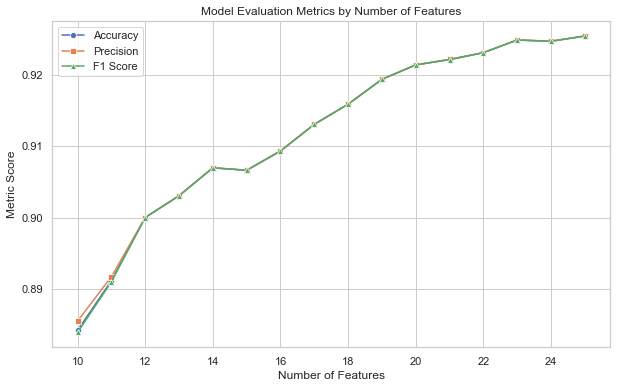

In [7]:
import seaborn as sns

def plot_evaluation_results_sns(csv_file):
    # Read the CSV file into a DataFrame
    df = pd.read_csv(csv_file)
    
    # Convert the 'Features' column to numeric for plotting
    df['Features'] = pd.to_numeric(df['Features'])
    
    # Sort the DataFrame based on the number of features
    df.sort_values('Features', inplace=True)

    # Initialize the matplotlib figure
    plt.figure(figsize=(10, 6))

    # Set the seaborn theme
    sns.set_theme(style="whitegrid")

    # Plot Accuracy
    sns.lineplot(data=df, x='Features', y='Accuracy', marker='o', label='Accuracy')
    
    # Plot Precision
    sns.lineplot(data=df, x='Features', y='Precision', marker='s', label='Precision')
    
    # Plot F1 Score
    sns.lineplot(data=df, x='Features', y='F1 Score', marker='^', label='F1 Score')

    # Finalizing the plot
    plt.title('Model Evaluation Metrics by Number of Features')
    plt.xlabel('Number of Features')
    plt.ylabel('Metric Score')
    plt.legend()
    plt.grid(True)

    # Show the plot
    plt.show()

# Example usage
plot_evaluation_results_sns('model_evaluation_results.csv')


HSIC Lasso (Hilbert-Schmidt Independence Criterion Least Absolute Shrinkage and Selection Operator) is a non-linear feature selection method that can be particularly powerful in scenarios where the relationship between features and the target variable is complex and not well-captured by linear models. It is designed to capture both linear and non-linear dependencies between variables using kernel methods, making it a versatile tool in the feature selection arsenal, especially for high-dimensional data.

### When HSIC Lasso Excels:

- **Non-linear Relationships:** HSIC Lasso can detect non-linear relationships between features and the target, outperforming linear methods like traditional LASSO or linear RFE when such relationships are present.
- **High-dimensional Data:** It's well-suited for scenarios where you have a large number of features, potentially with complex interdependencies.
- **Feature Relevance and Redundancy:** HSIC Lasso can help identify a subset of relevant features while considering their redundancy, aiming to select features that individually and collectively have strong predictive power.

### Considerations:

- **Computational Complexity:** HSIC Lasso's computational complexity can be higher than simpler linear methods, especially as the number of features grows, which might pose challenges for very large datasets.
- **Implementation and Interpretability:** Implementing HSIC Lasso might require more effort, and the results might be less interpretable to stakeholders unfamiliar with kernel methods compared to more straightforward linear models.
- **Dependency on Hyperparameters:** Like many machine learning methods, HSIC Lasso's performance depends on the choice of hyperparameters, such as the kernel type and its parameters. Selecting these requires careful tuning and validation.

### Comparing with RFE and LDA:

- **RFE (Recursive Feature Elimination)** with a linear model like LDA (Linear Discriminant Analysis) focuses on linear relationships and iteratively removes features to find an optimal subset. RFE can be very effective when the relationship between features and the target is approximately linear or when interpretability and computational efficiency are priorities.
- **HSIC Lasso** could potentially be a better choice when you suspect significant non-linear interactions between your features and the target variable, and you are dealing with high-dimensional data where capturing these complex relationships could lead to better model performance.

### Conclusion:

Whether HSIC Lasso is a better feature selection model for your specific problem depends on the nature of your dataset and the problem you're trying to solve. If non-linearity, high dimensionality, and complex feature interactions characterize your data, HSIC Lasso could offer significant advantages. However, for problems where linear relationships predominate or when simplicity, speed, and interpretability are key considerations, traditional methods like RFE with LDA or other linear models might be more appropriate.

It's often beneficial to experiment with different feature selection methods, including HSIC Lasso and linear approaches, to empirically determine which method works best for your specific scenario.

In [8]:
# Apply standard scaler to the dataset
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Merge the training set and the target variable
train_df = pd.DataFrame(X_train_scaled, columns=features)
train_df['phishing'] = y_train

# Save the training set to a CSV file
train_df.to_csv('train.csv', index=False)

# Testing with HSIC Lasso for Feature Selection
def hsic_lasso_feature_selection():
    hsic_lasso = HSICLasso()    
    hsic_lasso.input("train.csv", output_list = ["phishing"])
    hsic_lasso.classification(20, 5, 2)
    hsic_lasso.dump()
    hsic_lasso.save_param()

if not os.path.exists('param.csv'):
    hsic_lasso_feature_selection()

Block HSIC Lasso B = 5.
M set to 2.
Using Gaussian kernel for the features, Delta kernel for the outcomes.
============================================== HSICLasso : Result ==================================================
| Order | Feature      | Score | Top-5 Related Feature (Relatedness Score)                                          |
| 1     | qty_mx_servers | 1.000 | qty_nameservers (0.353), time_domain_activation (0.340), qty_slash_directory (0.330), qty_redirects (0.329), qty_vowels_domain (0.324)|
| 2     | qty_vowels_domain | 0.925 | domain_length (0.696), length_url   (0.383), qty_slash_directory (0.371), qty_slash_url (0.363), time_domain_activation (0.355)|
| 3     | time_domain_activation | 0.834 | time_domain_expiration (0.466), qty_slash_directory (0.374), qty_dot_file (0.366), qty_dot_directory (0.363), qty_vowels_domain (0.355)|
| 4     | time_response | 0.789 | qty_redirects (0.382), qty_slash_directory (0.341), qty_dot_directory (0.332), qty_dot_file (0.331), ttl_h

In [9]:
params = pd.read_csv('param.csv')
HSIC_feats = params[params.columns[0]].tolist()

print(HSIC_feats)

['qty_mx_servers', 'qty_vowels_domain', 'time_domain_activation', 'time_response', 'ttl_hostname', 'qty_redirects', 'asn_ip', 'domain_length', 'qty_slash_directory', 'qty_nameservers', 'domain_spf', 'qty_dot_domain', 'time_domain_expiration', 'tls_ssl_certificate', 'qty_dot_url', 'qty_dot_file', 'file_length', 'length_url', 'qty_slash_url', 'qty_dot_directory']


## Implementing & Comparing Various Machine Learning Models
<a class="anchor" id="IMPLEMENT"></a>
Defining functions to tune the feature selection algorithm. Each model that is tested will be evaluated via cross-validation to ensure that the results are not due to chance alone.

In [10]:
import numpy as np
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import cross_validate, StratifiedKFold

def test_models_with_cv_metrics(X, y, n_splits=5):
    # Define Stratified K-Fold cross-validator
    cv = StratifiedKFold(n_splits=n_splits)

    # List of models to test
    models = [
        LogisticRegression(max_iter=1000),
        RandomForestClassifier(n_estimators=100),
        SVC(probability=True),  # Enable probability for SVC
        XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
        CatBoostClassifier(verbose=0)  # Suppressing verbose output
    ]
    
    model_names = ['Logistic Regression', 'Random Forest', 'SVC', 'XGBClassifier', 'CatBoostClassifier']
    results = []

    # Define metrics to evaluate
    scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted']

    # Iterate over each model
    for model, name in zip(models, model_names):
        pipeline = make_pipeline(StandardScaler(), model)
        
        # Calculate cross-validated scores for all metrics
        scores = cross_validate(pipeline, X, y, cv=cv, scoring=scoring, n_jobs=2)
        
        # Calculate mean scores and standard deviation
        mean_accuracy = np.mean(scores['test_accuracy'])
        std_accuracy = np.std(scores['test_accuracy'])
        mean_precision = np.mean(scores['test_precision_weighted'])
        mean_recall = np.mean(scores['test_recall_weighted'])
        mean_f1 = np.mean(scores['test_f1_weighted'])
        
        print(f'{name} CV Accuracy: {mean_accuracy:.3f} ({std_accuracy:.3f})')
        
        # Store results
        results.append({
            'Model': name,
            'CV Accuracy Mean': mean_accuracy,
            'CV Accuracy Std': std_accuracy,
            'CV Precision Mean': mean_precision,
            'CV Recall Mean': mean_recall,
            'CV F1 Mean': mean_f1,
        })

    # Convert results to a DataFrame for easy visualization
    results_df = pd.DataFrame(results)
    results_df.to_csv('model_cv_results.csv', index=False)
    return results_df

### Model Selection and Training
Here we will experiment on three different models: Logistic Regression, Decision Tree, and XGBoost

In [11]:
# Splitting the data into training and test sets once again based on results from RFE algorithm
X_train = X_train[HSIC_feats]
X_test = X_test[HSIC_feats]

if not os.path.exists('model_cv_results.csv'):
    results_df = test_models_with_cv_metrics(X, Y)

Logistic Regression CV Accuracy: 0.900 (0.001)
Random Forest CV Accuracy: 0.957 (0.001)
SVC CV Accuracy: 0.917 (0.002)
XGBClassifier CV Accuracy: 0.956 (0.001)
CatBoostClassifier CV Accuracy: 0.956 (0.001)


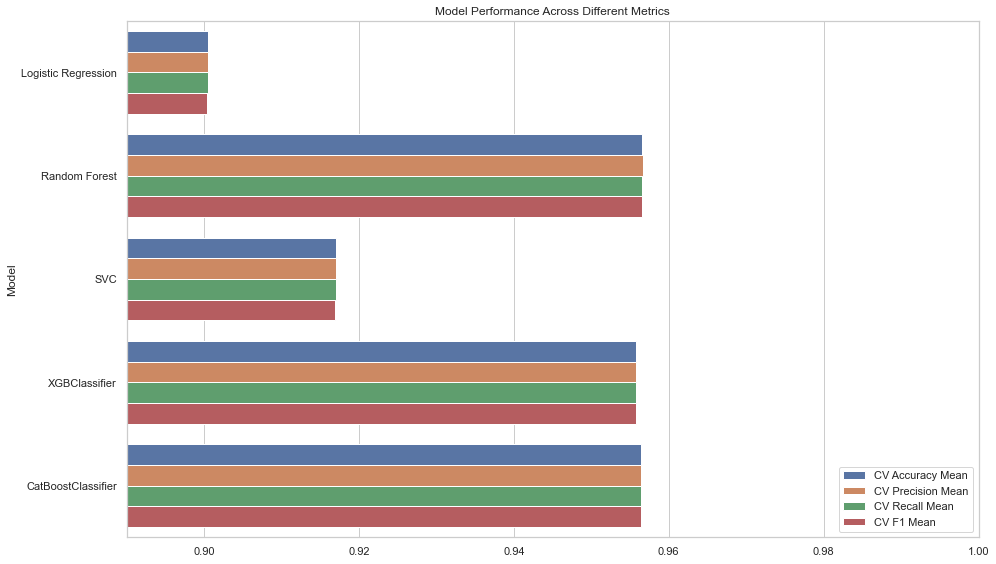

In [ ]:
import seaborn as sns

# Read the CSV file into a DataFrame
original_results_df = pd.read_csv('model_cv_results.csv')

def plot_model_performance(results_df):
    # Set the style of seaborn
    sns.set_theme(style="whitegrid")

    # Melt the DataFrame to make it suitable for sns.barplot
    results_melted = pd.melt(results_df, id_vars=["Model"], var_name="Metric", value_name="Score",
                             value_vars=["CV Accuracy Mean", "CV Precision Mean", "CV Recall Mean", "CV F1 Mean"])

    plt.figure(figsize=(14, 8))
    sns.barplot(x="Score", y="Model", hue="Metric", data=results_melted)
    
    plt.title('Model Performance Across Different Metrics')
    plt.xlabel('')
    plt.ylabel('Model')
    plt.xlim(0.89, 1)  # Assuming the scores are normalized between 0 and 1
    plt.legend(loc="lower right")
    
    plt.tight_layout()
    plt.show()

plot_model_performance(original_results_df)

# Hyperparameter Tuning

In [13]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from tqdm import tqdm
import pandas as pd

def tune_hyperparameters(X_train, y_train):
    # Define the models and hyperparameters to tune
    models_params = {
        'RandomForestClassifier': {
            'model': RandomForestClassifier(),
            'params': {
                'n_estimators': [100, 200, 300],  # Number of trees in the forest
                'max_depth': [None, 10, 20, 30],  # Maximum depth of the tree
                'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
                'min_samples_leaf': [1, 2, 4],  # Minimum number of samples required to be at a leaf node
                'max_features': ['auto', 'sqrt', 'log2'],  # The number of features to consider when looking for the best split
                'criterion': ['gini', 'entropy'],  # The function to measure the quality of a split
                'bootstrap': [True, False]  # Whether bootstrap samples are used when building trees
            }
        },
        'XGBClassifier': {
            'model': XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
            'params': {
                'n_estimators': [100, 200],
                'max_depth': [6, 10],
                'learning_rate': [0.1, 0.01]
            }
        },
        'CatBoostClassifier': {
            'model': CatBoostClassifier(verbose=0),
            'params': {
                'iterations': [100, 200],
                'depth': [6, 10],
                'learning_rate': [0.1, 0.01]
            }
        }
    }

    tuning_results = []
    
    # Wrapping the loop with tqdm for progress visualization
    for model_name, mp in tqdm(models_params.items(), desc="Tuning Models"):
        clf = GridSearchCV(mp['model'], mp['params'], cv=5, scoring='accuracy', verbose=0)
        clf.fit(X_train, y_train)
        tuning_results.append({
            'Model': model_name,
            'Best Score': clf.best_score_,
            'Best Params': clf.best_params_
        })
        
    tuning_results = pd.DataFrame(tuning_results)
    tuning_results.to_csv('tuned_models.csv', index=False)
    return tuning_results

if not os.path.exists('tuned_models.csv'):
    tuning_results = tune_hyperparameters(X, Y)

Tuning Models:   0%|          | 0/3 [36:35<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_comparison(original_results_df, tuned_results_df):
    rename_mapping = {
        'Random Forest': 'RandomForestClassifier'
    }
    original_results_df['Model'] = original_results_df['Model'].replace(rename_mapping)
    tuned_results_df = tuned_results_df.rename(columns={'Best Score': 'CV Accuracy Mean (Tuned)'})
    
    # Check if there's any mismatch in model names
    print("Original Models:", original_results_df['Model'].unique())
    print("Tuned Models:", tuned_results_df['Model'].unique())
    
    # Attempt merging only if there are matching models
    if not pd.merge(original_results_df, tuned_results_df, on='Model').empty:
        # Merging the original and tuned scores for plotting
        merged_df = pd.merge(original_results_df[['Model', 'CV Accuracy Mean']], 
                             tuned_results_df[['Model', 'CV Accuracy Mean (Tuned)']], 
                             on='Model', 
                             how='inner')
        
        if not merged_df.empty:
            melted_df = pd.melt(merged_df, id_vars=["Model"], var_name="Metric", value_name="Score")
            
            sns.set_theme(style="whitegrid")
            plt.figure(figsize=(10, 6))
            sns.barplot(x='Model', y='Score', hue='Metric', data=melted_df)
            plt.title('Model Performance Before and After Hyperparameter Tuning')
            plt.ylabel('Accuracy')
            plt.xticks(rotation=0)
            plt.legend(title='Metric')
            plt.tight_layout()
            plt.ylim(0.95, 0.97)  # Assuming the scores are normalized between 0 and 1
            plt.show()
        else:
            print("Merged DataFrame is empty. Check model names and column names.")
    else:
        print("No matching models found between original and tuned results.")

tuned_models_df = pd.read_csv('tuned_models.csv')
plot_comparison(original_results_df, tuned_models_df)

# Training Final Model

In [ ]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.preprocessing import StandardScaler
import numpy as np

class AveragingModel(BaseEstimator, ClassifierMixin):
    def __init__(self, models):
        self.models = models
        self.scaler = StandardScaler()  # Initialize the scaler
    
    def fit(self, X, y):
        # Fit each of the models with the scaled training data
        for model in self.models:
            model.fit(X, y)
        return self
    
    def predict_proba(self, X):
        # Get predictions from each model and average them
        avg_proba = np.mean([model.predict_proba(X) for model in self.models], axis=0)
        return avg_proba
    
    def predict(self, X):
        # Convert averaged probabilities into final predictions
        avg_proba = self.predict_proba(X)
        final_predictions = np.argmax(avg_proba, axis=1)
        return final_predictions


In [ ]:
# Import the best performing hyperparameters
import ast
tuned_models_df = pd.read_csv('tuned_models.csv')
best_params = tuned_models_df.set_index('Model')['Best Params'].to_dict()

RF_hyperparams = ast.literal_eval(best_params['RandomForestClassifier'])
XGB_hyperparams = ast.literal_eval(best_params['XGBClassifier'])
CAT_hyperparams = ast.literal_eval(best_params['CatBoostClassifier'])

# Assign the best hyperparameters to the corresponding models
RF = RandomForestClassifier(**RF_hyperparams)
XGB = XGBClassifier(**XGB_hyperparams)
CAT = CatBoostClassifier(**CAT_hyperparams, verbose=0)

In [ ]:
# Create the averaging wrapper model
averaging_model = AveragingModel(models=[RF, XGB, CAT])

# Convert X_train and y_train to pandas DataFrame
X_train = pd.DataFrame(X_train, columns=HSIC_feats)
y_train = pd.Series(y_train)

# Scale the training data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Fit the wrapper model with your training data
averaging_model.fit(X_train_scaled, y_train)

In [ ]:
# Scale the test data
X_test_scaled = scaler.transform(X_test)

accuracy = accuracy_score(y_test, averaging_model.predict(X_test_scaled))
print("Accuracy:", accuracy)

# Get predictions on the test set
predictions = averaging_model.predict(X_test_scaled)

# Compute confusion matrix
cm = confusion_matrix(y_test, predictions)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt

def plot_roc_curves(X_test, y_test, models, model_names):
    plt.figure(figsize=(10, 8))
    
    for model, name in zip(models, model_names):
        # Get the probability scores of the positive class
        y_scores = model.predict_proba(X_test)[:, 1]
        
        # Compute ROC curve and ROC area for each class
        fpr, tpr, _ = roc_curve(y_test, y_scores)
        roc_auc = auc(fpr, tpr)
        
        plt.plot(fpr, tpr, lw=2, label=f'{name} (area = {roc_auc:.2f})')
    
    plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

# Prepare models and names for plotting
models = [RF, XGB, CAT, averaging_model]
model_names = ['Random Forest', 'XGBoost', 'CatBoost', 'Averaging Model']

# Plot ROC curves
plot_roc_curves(X_test_scaled, y_test, models, model_names)

# Extrapolation

In [ ]:
from joblib import dump, load
X = pd.DataFrame(X, columns=HSIC_feats)
Y = pd.Series(Y)

# Scale the X data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

if not os.path.exists('averaging_model.joblib'):
    averaging_model.fit(X, Y)
    dump(averaging_model, 'averaging_model.joblib')
    
# Export the scaler to a file
if not os.path.exists('scaler.joblib'):
    dump(scaler, 'scaler.joblib')

### Testing retrieval methods for params

Splitting the URL into its constituents 

In [ ]:
from urllib.parse import urlparse, parse_qs

def split_url(url):
    # Parse the URL
    parsed_url = urlparse(url)
    split_path = parsed_url.path.split('/')
    
    # Initialize components with -1 (indicating "does not exist")
    components = {
        "domain": -1,
        "directory": -1,
        "file": -1,
        "parameters": -1
    }
    
    # Extract domain
    if parsed_url.netloc:
        components["domain"] = parsed_url.netloc
    
    # Extract file and directory
    if split_path:
        if len(split_path) > 1:
            # Join all parts except the last one as directory
            components["directory"] = '/'.join(split_path[:-1])
            if split_path[-1]:  # Check if the last part is not empty, indicating a file
                components["file"] = split_path[-1]
        elif split_path[0]:  # Only one part, could be either directory or file
            components["file"] = split_path[0]
    
    # Extract parameters (query string)
    if parsed_url.query:
        # Parse query string into a dictionary
        components["parameters"] = parse_qs(parsed_url.query)
    
    return components

In [ ]:
from urllib.parse import urlparse

def calculate_url_attributes(url):
    components = split_url(url)  # Use your split_url function
    domain = components['domain']
    directory = components['directory']
    file = components['file']
    
    # Initialize dictionary to store attributes
    attributes = {
        'qty_slash_url': url.count('/'),
        'qty_dot_url': url.count('.'),
        'length_url': len(url),
        'file_length': len(file) if file != -1 else 0,
        'directory_length': len(directory) if directory != -1 else 0,
        'qty_dot_file': file.count('.') if file != -1 and '.' in file else 0,
        'qty_slash_directory': directory.count('/') if directory != -1 else 0,
        'qty_dot_domain': domain.count('.') if domain != -1 else 0,
        'domain_length': len(domain) if domain else -1,
        'qty_vowels_domain': sum(map(domain.lower().count, "aeiou")) if domain else -1
    }

    return attributes


In [ ]:
import requests

def get_asn(ip_address, access_token='dbf71fc14e52e2'):
    try:
        response = requests.get(f'https://ipinfo.io/{ip_address}/json?token={access_token}')
        data = response.json()
        org_field = data.get('org', 'N/A')
        asn = org_field.split(' ')[0] if org_field != 'N/A' else -1
        
        return asn[2:]
    except Exception as e:
        print(f"Error retrieving ASN for IP {ip_address}: {e}")
        return -1


In [ ]:
from datetime import datetime
import dns.resolver
import requests
import socket
import whois
from urllib.parse import urlparse

def perform_external_lookups(url):
    features = {}
    domain = split_url(url)['domain']
    
    # Initialize features to handle errors individually
    features['time_domain_activation'] = -1
    features['time_domain_expiration'] = -1
    features['qty_mx_servers'] = 0
    features['qty_nameservers'] = 0
    features['ttl_hostname'] = -1
    features['asn_ip'] = -1  # Placeholder for ASN lookup
    features['time_response'] = -1
    features['qty_redirects'] = -1
    features['tls_ssl_certificate'] = -1
    features['domain_spf'] = -1

    try:
        w = whois.whois(domain)
        if w.creation_date:
            if isinstance(w.creation_date, list):  # Handle multiple creation dates
                w.creation_date = w.creation_date[0]
            features['time_domain_activation'] = (datetime.now() - w.creation_date).days
        if w.expiration_date:
            if isinstance(w.expiration_date, list):  # Handle multiple expiration dates
                w.expiration_date = w.expiration_date[0]
            features['time_domain_expiration'] = (w.expiration_date - datetime.now()).days
    except Exception as e:
        print(f"Error during WHOIS lookup: {e}")
    
    try:
        dns_resolver = dns.resolver.Resolver()
        mx_records = dns_resolver.resolve(domain, 'MX')
        features['qty_mx_servers'] = len(mx_records)
    except:
        pass  # Feature remains -1 if error occurs

    try:
        ns_records = dns_resolver.resolve(domain, 'NS')
        features['qty_nameservers'] = len(ns_records)
    except:
        pass  # Feature remains -1 if error occurs

    try:
        features['ttl_hostname'] = dns_resolver.resolve(domain, 'A').rrset.ttl
    except:
        pass  # Feature remains -1 if error occurs

    try:
        start_time = datetime.now()
        response = requests.get(url, timeout=100)
        end_time = datetime.now()
        features['time_response'] = (end_time - start_time).total_seconds()
        features['qty_redirects'] = len(response.history)
        features['tls_ssl_certificate'] = 1 if response.url.startswith('https') else 0
    except Exception as e:
        print(f"Error making HTTP request: {e}")

    try:
        txt_records = dns_resolver.resolve(domain, 'TXT')
        spf_record = any(record.to_text().startswith('"v=spf1') for record in txt_records)
        features['domain_spf'] = 1 if spf_record else 0
    except:
        pass

    try:
        # Resolve the domain to an IP address for the ASN lookup
        ip_address = socket.gethostbyname(domain)
        features['asn_ip'] = get_asn(ip_address)
    except Exception as e:
        print(f"Error resolving domain to IP for ASN lookup: {e}")
        features['asn_ip'] = -1  # Set to -1 if there's an error
        
    return features

In [ ]:
def retrieveData(URL: str) -> pd.DataFrame:
    url_attributes = calculate_url_attributes(URL)
    
    # Get the external lookups using the domain
    external_lookups = perform_external_lookups(URL)
    data = {**url_attributes, **external_lookups}
    df = pd.DataFrame([data])
    
    return df

In [ ]:
test = retrieveData("https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&cad=rja&uact=8&ved=2ahUKEwiIiNLRkOKEAxVGzDgGHRvVB9AQFnoECBEQAQ&url=https%3A%2F%2Fdasoulmedia.com%2F&usg=AOvVaw222pz_A93K0EQCDZVudy9f&opi=89978449")

# reorder the columns based on HSIC_feats
test = test[HSIC_feats]

# Scale the test data
scaler = load('scaler.joblib')
test_scaled = scaler.transform(test)

test

In [ ]:
# Load the model from disk
loaded_model = load('averaging_model.joblib')

# Make predictions
predictions = loaded_model.predict(test_scaled)

# Or get probability predictions
probability_predictions = loaded_model.predict_proba(test_scaled)

print(predictions, probability_predictions)